## Import dependencies

In [2]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import stats
from scipy.stats import pearsonr
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
warnings.filterwarnings("ignore")

## Read data

In [4]:
df_AL = pd.read_csv("../data/amide_AL_set.csv")
df_EL = pd.read_csv("../data/enol_EL_set.csv")

In [5]:
df_combined = pd.concat([df_AL, df_EL], axis=0, ignore_index=True)

In [6]:
selected_features = ['nbo_C2_CMC', 'nbo_X3_CMC', 'vbur_Co_CMC']  # selected features
feature_unit = ['e', 'e', '%']  # units for plotting
target_names = ['0 ("negatives")', '1 ("positives")']  # target classes' labels
marker_shapes = {'amide': 's', 'enol': 'o'}  # markers for amides(X=N) and enols(X=C)

## Reactivity classification

In [8]:
# mean from the yield distribution
mean_yield = df_combined['exp_yield'].mean()
print(f"Mean yield = {mean_yield:.2f} %")

Mean yield = 37.95 %


**Note:** The following code segment is a modified version of the original script from Newman-Stonebraker et al.'s reported work.


*   Reference article: Newman-Stonebraker, S. H.; Smith, S. R.; Borowski, J. E.; Peters, E.; Gensch, T.; Johnson, H. C.; Sigman, M. S.; Doyle, A. G. Univariate Classification of Phosphine Ligation State and Reactivity in Cross-Coupling Catalysis. *Science* **2021**, *374*, 301-308, DOI: [10.1126/science.abj4213](https://www.science.org/doi/10.1126/science.abj4213)
*   Reference script: https://github.com/sigmangroup/thresold


Feature: nbo_C2_CMC
Min: 0.36613, Max: 0.69386, Unique values: 20
Class balance: [11  9]
Decision threshold = 0.57
Accuracy: 0.90
F1 Score: 0.90
Recall: 1.00
Classification Report: 
                 precision    recall  f1-score   support

0 ("negatives")       1.00      0.82      0.90        11
1 ("positives")       0.82      1.00      0.90         9

       accuracy                           0.90        20
      macro avg       0.91      0.91      0.90        20
   weighted avg       0.92      0.90      0.90        20

------------------------------------------------------------
xx.shape: (7560, 36), yy.shape: (7560, 36)
Z.shape: (7560, 36)


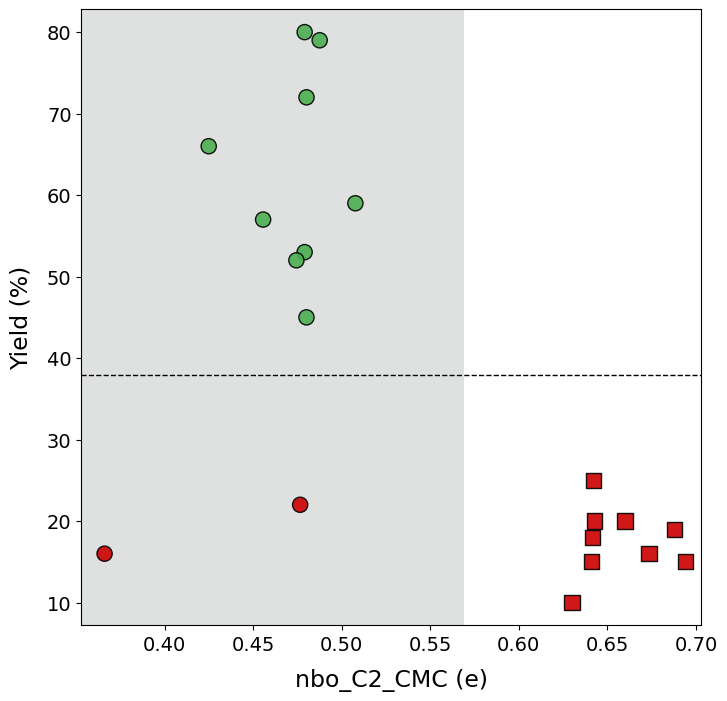







Feature: nbo_X3_CMC
Min: -0.613, Max: -0.45396, Unique values: 20
Class balance: [11  9]
Decision threshold = -0.54
Accuracy: 0.90
F1 Score: 0.90
Recall: 1.00
Classification Report: 
                 precision    recall  f1-score   support

0 ("negatives")       1.00      0.82      0.90        11
1 ("positives")       0.82      1.00      0.90         9

       accuracy                           0.90        20
      macro avg       0.91      0.91      0.90        20
   weighted avg       0.92      0.90      0.90        20

------------------------------------------------------------
xx.shape: (7560, 18), yy.shape: (7560, 18)
Z.shape: (7560, 18)


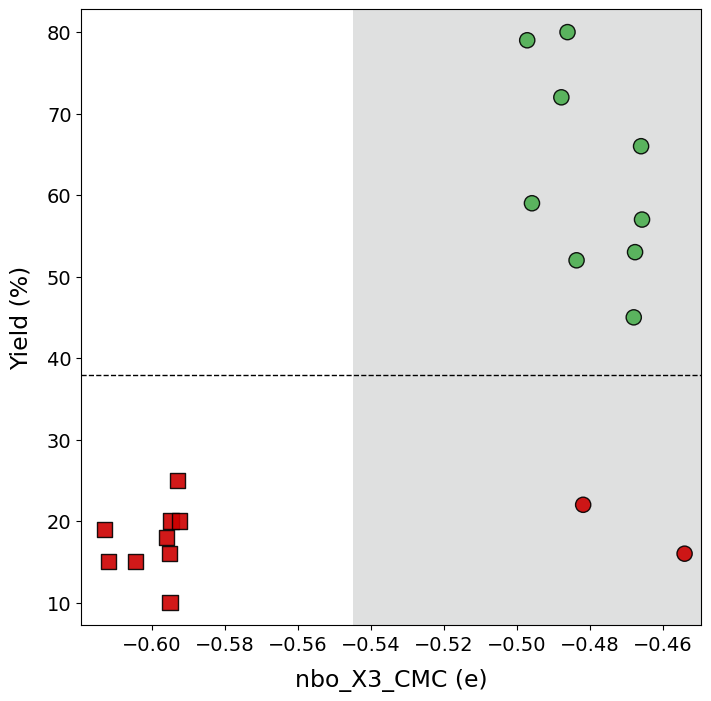







Feature: vbur_Co_CMC
Min: 70.38, Max: 74.08, Unique values: 20
Class balance: [11  9]
Decision threshold = 72.84
Accuracy: 0.65
F1 Score: 0.67
Recall: 0.78
Classification Report: 
                 precision    recall  f1-score   support

0 ("negatives")       0.75      0.55      0.63        11
1 ("positives")       0.58      0.78      0.67         9

       accuracy                           0.65        20
      macro avg       0.67      0.66      0.65        20
   weighted avg       0.68      0.65      0.65        20

------------------------------------------------------------
xx.shape: (7560, 400), yy.shape: (7560, 400)
Z.shape: (7560, 400)


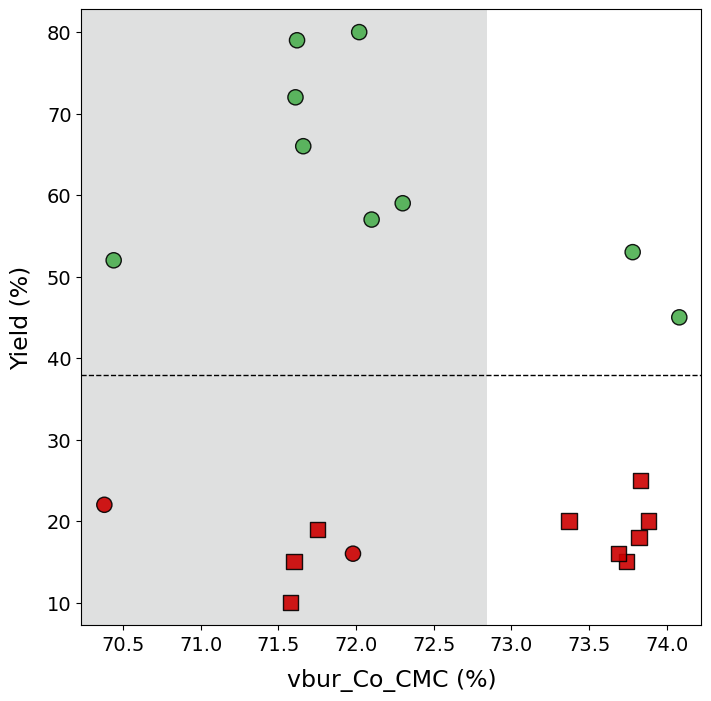

In [10]:
# threshold analysis for selected features

y_cut = mean_yield  # yield cutoff to define ligand's reactivity as acceptable/unacceptable for the reaction

for i, feature in enumerate(selected_features):

    y_all = df_combined['exp_yield'].dropna()  # experimental yield data
    X_all = df_combined[feature].loc[y_all.index].values
    ligand_types = df_combined['ligand_type'].loc[y_all.index]  # for amides(X=N) and enols(X=C) type
    
    # for feature statistics
    print(f"Feature: {feature}")  
    print(f"Min: {X_all.min()}, Max: {X_all.max()}, Unique values: {len(np.unique(X_all))}")

    # use the complete dataset for threshold analysis
    X_use = X_all
    y_use = y_all
    ligand_use = ligand_types

    y_class = np.array([0 if i < y_cut else 1 for i in y_use])  # to binarize the yield based on the set threshold value

    print(f"Class balance: {np.bincount(y_class)}")  # check class balance

    if len(np.unique(y_class)) > 1:

        # decision tree classifier fitting with balanced class weights
        dt = DecisionTreeClassifier(max_depth=1, class_weight='balanced')
        dt.fit(X_use.reshape(-1, 1), y_class)

        # print metrics and decision threshold
        print(f"Decision threshold = {dt.tree_.threshold[0]:.2f}")
        print(f"Accuracy: {dt.score(X_use.reshape(-1, 1), y_class):.2f}")
        print(f"F1 Score: {metrics.f1_score(y_class, dt.predict(X_use.reshape(-1, 1))):.2f}")
        print(f"Recall: {metrics.recall_score(y_class, dt.predict(X_use.reshape(-1, 1)), pos_label=1, average='binary'):.2f}")
        print(f"Classification Report: \n{metrics.classification_report(y_class, dt.predict(X_use.reshape(-1, 1)), target_names=target_names)}")
        print('-' * 60)

        # for plotting
        plot_step = 0.01
        x_min, x_max = X_all.min(), X_all.max()
        y_min, y_max = y_all.min(), y_all.max()

        cMap_background = ListedColormap(['white', '#dfe0e0'])  # background (region) color: white (negative) and green (positive)
        cMap_points = ListedColormap(["#c00", "#4caf50"])  # marker color: red (unacceptable) and green (acceptable)

        # ideal classification case: all green markers in green region and all red markers in the white region

        dx, dy = x_max - x_min, y_max - y_min
        xx, yy = np.meshgrid(np.arange(x_min - 0.04 * dx, x_max + 0.04 * dx, plot_step),
                             np.arange(y_min - 0.04 * dy, y_max + 0.04 * dy, plot_step))

        print(f'xx.shape: {xx.shape}, yy.shape: {yy.shape}')  # for cross reference

        plt.figure(figsize=(8, 8))
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

        # predict on the mesh grid
        Z = dt.predict(xx.ravel().reshape(-1, 1))
        Z = Z.reshape(xx.shape)

        print(f'Z.shape: {Z.shape}')  # for cross reference

        plt.contourf(xx, yy, Z, cmap=cMap_background)

        plt.xlabel(f"{feature} ({feature_unit[i]})", fontsize=17, labelpad=10)
        plt.ylabel("Yield (%)", fontsize=17, labelpad=10)

        # the scatter plot 
        for ligand_type in np.unique(ligand_use):
            mask = ligand_use == ligand_type
            plt.scatter(X_use[mask], y_use[mask], c=y_class[mask], cmap=cMap_points, alpha=0.9, edgecolor="black", s=120,
                        marker=marker_shapes[ligand_type], label=ligand_type, linewidths=1)

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        # horizontal dashed line for cutoff indicator
        plt.axhline(y=y_cut, color='black', linestyle='--', linewidth=1.0)

        plt.savefig(f'react_class_{feature}.png', dpi=300, bbox_inches='tight')

        # plt.legend(title="Ligand Type", fontsize=15)
        plt.show()
        print('\n'*5)

    else:
        print(f"Classification for feature {feature} not possible at the considered cutoff.")
        print('\n'*5)


**Note:** Since the feature scale of the feature IE_CMC was very narrowly ranged, the above approach was modified for the 2D space. An appropriate meshgrid range for IE_CMC was mannually set.

Feature: IE_CMC
Min: -0.003517781, Max: 0.003219379, Unique values: 20
Class balance: [11  9]
Decision threshold = -0.001
Accuracy: 0.70
F1 Score: 0.67
Recall: 0.67
Classification Report: 
                 precision    recall  f1-score   support

0 ("negatives")       0.73      0.73      0.73        11
1 ("positives")       0.67      0.67      0.67         9

       accuracy                           0.70        20
      macro avg       0.70      0.70      0.70        20
   weighted avg       0.70      0.70      0.70        20

------------------------------------------------------------
xx.shape: (800000, 88), yy.shape: (800000, 88)
Z.shape: (800000, 88)


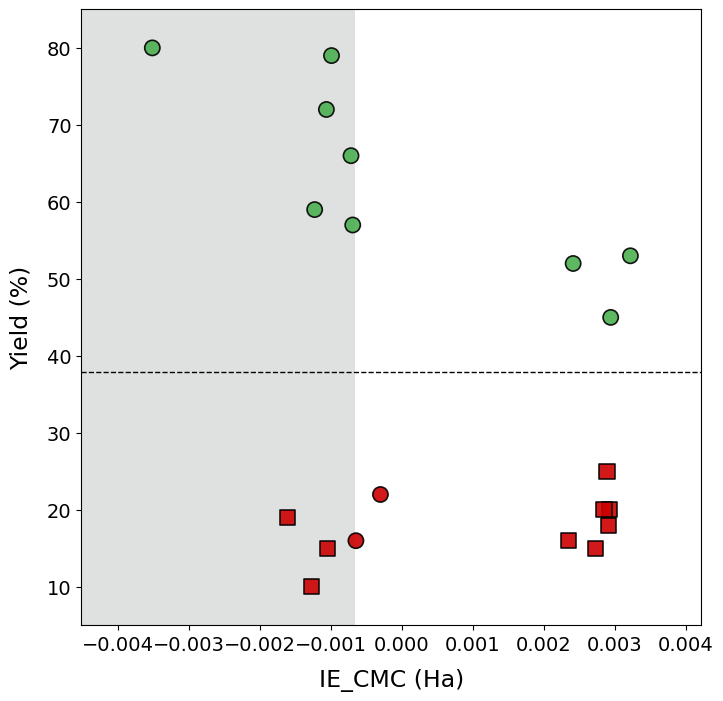

In [12]:
# for the specific feature to analyze

feature = 'IE_CMC'


y_all = df_combined['exp_yield'].dropna()
X_all = df_combined[feature].loc[y_all.index].values
ligand_types = df_combined['ligand_type'].loc[y_all.index]

print(f"Feature: {feature}")
print(f"Min: {X_all.min()}, Max: {X_all.max()}, Unique values: {len(np.unique(X_all))}")

X_use = X_all
y_use = y_all
ligand_use = ligand_types

y_class = np.array([0 if i < y_cut else 1 for i in y_use])

print(f"Class balance: {np.bincount(y_class)}")


if len(np.unique(y_class)) > 1:
    dt = DecisionTreeClassifier(max_depth=1, class_weight='balanced')
    dt.fit(X_use.reshape(-1, 1), y_class)

    print(f"Decision threshold = {dt.tree_.threshold[0]:.3f}")  # for threshold value upto 3 decimal places
    print(f"Accuracy: {dt.score(X_use.reshape(-1, 1), y_class):.2f}")
    print(f"F1 Score: {metrics.f1_score(y_class, dt.predict(X_use.reshape(-1, 1))):.2f}")
    print(f"Recall: {metrics.recall_score(y_class, dt.predict(X_use.reshape(-1, 1)), pos_label=1, average='binary'):.2f}")
    print(f"Classification Report: \n{metrics.classification_report(y_class, dt.predict(X_use.reshape(-1, 1)), target_names=target_names)}")
    print('-' * 60)

    # adjustment of the plot_step for narrow range
    plot_step = 0.0001
    x_min, x_max = X_all.min() - 0.001, X_all.max() + 0.001   # addition of smaller buffer
    y_min, y_max = y_all.min() - 5, y_all.max() + 5


    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    print(f'xx.shape: {xx.shape}, yy.shape: {yy.shape}')

    plt.figure(figsize=(8, 8))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)

    print(f'Z.shape: {Z.shape}')

    plt.contourf(xx, yy, Z, cmap=cMap_background)

    plt.xlabel(f"{feature} (Ha)", fontsize=17, labelpad=10)
    plt.ylabel("Yield (%)", fontsize=17, labelpad=10)

    for ligand_type in np.unique(ligand_use):
        mask = ligand_use == ligand_type
        plt.scatter(X_use[mask], y_use[mask], c=y_class[mask], cmap=cMap_points, alpha=0.9, edgecolor="black", s=120,
                    marker=marker_shapes[ligand_type], label=ligand_type, linewidths=1.2)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.axhline(y=y_cut, color='black', linestyle='--', linewidth=1.0)

    # plt.legend(title="Ligand Type", fontsize=15)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.savefig(f'react_class_IE_CMC.png', dpi=300, bbox_inches='tight')

    plt.show()
    print('\n'*5)

else:
    print(f"Classification for feature {feature} not possible at the considered cutoff.")
    print('\n'*5)

Feature: IE_CMC
Min: -2.2074392375290004, Max: 2.020189296911, Unique values: 20
Class balance: [11  9]
Decision threshold = -0.421
Accuracy: 0.70
F1 Score: 0.67
Recall: 0.67
Classification Report: 
                 precision    recall  f1-score   support

0 ("negatives")       0.73      0.73      0.73        11
1 ("positives")       0.67      0.67      0.67         9

       accuracy                           0.70        20
      macro avg       0.70      0.70      0.70        20
   weighted avg       0.70      0.70      0.70        20

------------------------------------------------------------
xx.shape: (8000, 443), yy.shape: (8000, 443)
Z.shape: (8000, 443)


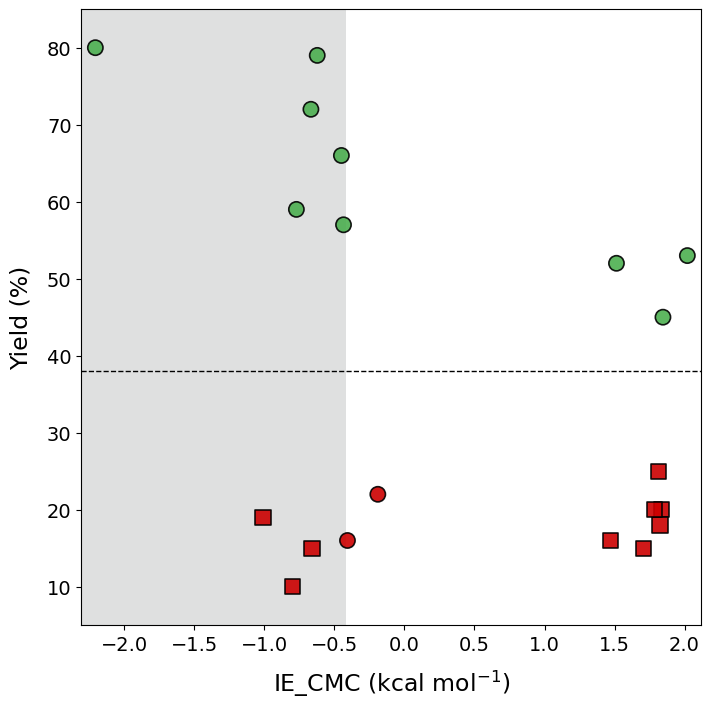

In [13]:
# for the specific feature to analyze

feature = 'IE_CMC'


y_all = df_combined['exp_yield'].dropna()
# X_all = df[feature].loc[y_all.index].values
X_all = df_combined[feature].loc[df_combined['exp_yield'].dropna().index].values*627.509  # converting IE's scale from unit Ha to kcal/mol (1 Ha = 627.509 kcal/mol)
ligand_types = df_combined['ligand_type'].loc[y_all.index]

print(f"Feature: {feature}")
print(f"Min: {X_all.min()}, Max: {X_all.max()}, Unique values: {len(np.unique(X_all))}")

X_use = X_all
y_use = y_all
ligand_use = ligand_types

y_class = np.array([0 if i < y_cut else 1 for i in y_use])

print(f"Class balance: {np.bincount(y_class)}")


if len(np.unique(y_class)) > 1:
    dt = DecisionTreeClassifier(max_depth=1, class_weight='balanced')
    dt.fit(X_use.reshape(-1, 1), y_class)

    print(f"Decision threshold = {dt.tree_.threshold[0]:.3f}")  # for threshold value upto 3 decimal places
    print(f"Accuracy: {dt.score(X_use.reshape(-1, 1), y_class):.2f}")
    print(f"F1 Score: {metrics.f1_score(y_class, dt.predict(X_use.reshape(-1, 1))):.2f}")
    print(f"Recall: {metrics.recall_score(y_class, dt.predict(X_use.reshape(-1, 1)), pos_label=1, average='binary'):.2f}")
    print(f"Classification Report: \n{metrics.classification_report(y_class, dt.predict(X_use.reshape(-1, 1)), target_names=target_names)}")
    print('-' * 60)

    # Adjustment of the plot_step for narrow range
    plot_step = 0.01  # adjusting step for kcal/mol scale
    x_min, x_max = X_all.min() - 0.1, X_all.max() + 0.1  # adjusting buffer for kcal/mol scale
    y_min, y_max = y_all.min() - 5, y_all.max() + 5


    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    print(f'xx.shape: {xx.shape}, yy.shape: {yy.shape}')

    plt.figure(figsize=(8, 8))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)

    print(f'Z.shape: {Z.shape}')

    plt.contourf(xx, yy, Z, cmap=cMap_background)

    plt.xlabel(f"{feature} " r"(kcal mol$^{-1}$)", fontsize=17, labelpad=10)
    plt.ylabel("Yield (%)", fontsize=17, labelpad=10)

    for ligand_type in np.unique(ligand_use):
        mask = ligand_use == ligand_type
        plt.scatter(X_use[mask], y_use[mask], c=y_class[mask], cmap=cMap_points, alpha=0.9, edgecolor="black", s=120,
                    marker=marker_shapes[ligand_type], label=ligand_type, linewidths=1.2)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.axhline(y=y_cut, color='black', linestyle='--', linewidth=1.0)

    # plt.legend(title="Ligand Type", fontsize=15)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.savefig(f'react_class_IE_CMC2.png', dpi=300, bbox_inches='tight')

    plt.show()
    print('\n'*5)

else:
    print(f"Classification for feature {feature} not possible at the considered cutoff.")
    print('\n'*5)

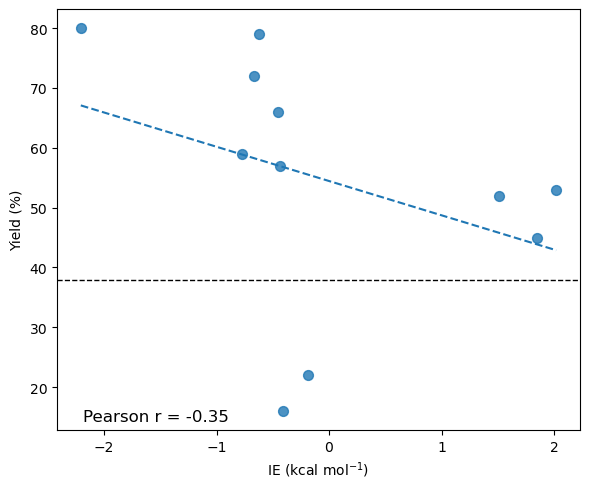

In [14]:
corr_value, _ = pearsonr(df_EL['exp_yield'], df_EL['IE_CMC'])  # Pearson correlation calculation

# scatterplot with regression line
plt.figure(figsize=(6, 5))
sns.regplot(x=df_EL['IE_CMC']*627.509, y='exp_yield', data=df_EL, scatter_kws={'s': 50}, line_kws={'lw': 1.5, "ls": "--"}, ci=None)

plt.axhline(y=y_cut, color='black', linestyle='--', linewidth=1.0)

plt.text(0.05, 0.05, f'Pearson r = {corr_value:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.xlabel(r'IE (kcal mol$^{-1}$)')
plt.ylabel('Yield (%)')

plt.tight_layout()
plt.savefig('IE_yield_corr_plot.png', dpi=300, bbox_inches='tight')
plt.show()

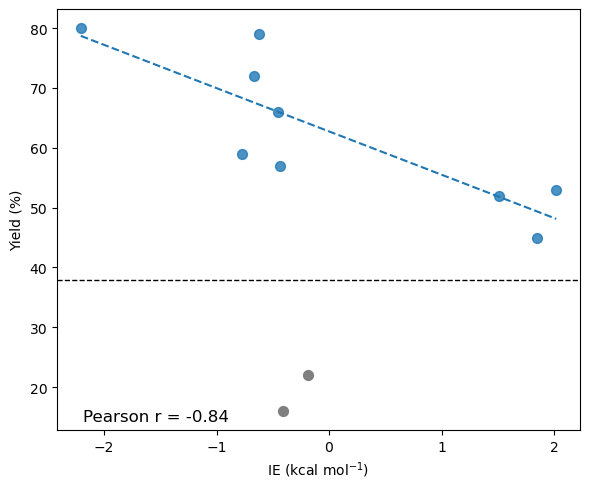

In [15]:
df_EL_exEL9_11 = df_EL[~df_EL['ligand_entry'].isin(['EL9', 'EL11'])]  # exclude EL9 and EL11 for regression

corr_value, _ = pearsonr(df_EL_exEL9_11['exp_yield'], df_EL_exEL9_11['IE_CMC'])

plt.figure(figsize=(6, 5))
sns.regplot(x=df_EL_exEL9_11['IE_CMC'] * 627.509, y='exp_yield', data=df_EL_exEL9_11, 
            scatter_kws={'s': 50}, line_kws={'lw': 1.5, "ls": "--"}, ci=None)

plt.axhline(y=y_cut, color='black', linestyle='--', linewidth=1.0)

# adding EL9 and EL11 back into the plot (grey colored)
lig_EL9 = df_EL[df_EL['ligand_entry'] == 'EL9']
plt.scatter(lig_EL9['IE_CMC'] * 627.509, lig_EL9['exp_yield'], color='grey', s=50)
lig_EL11 = df_EL[df_EL['ligand_entry'] == 'EL11']
plt.scatter(lig_EL11['IE_CMC'] * 627.509, lig_EL11['exp_yield'], color='grey', s=50)

plt.text(0.05, 0.05, f'Pearson r = {corr_value:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.xlabel(r'IE (kcal mol$^{-1}$)')
plt.ylabel('Yield (%)')

plt.tight_layout()
plt.savefig('IE_yield_corr_plot2.png', dpi=300, bbox_inches='tight')
plt.show()